# CNA PREP and RESULTS TISSUE CELLS
## Sid Gurajala
## 05/01/2023

## Libraries 

In [3]:
source("/data/srlab/ssg34/SLE_kidney_v2/scripts/libs/kidney_utils.r")
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% 
                        rename(Final_Site = Site) %>% select(-sample)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis



Attaching package: ‘singlecellmethods’


The following object is masked from ‘package:SeuratObject’:

    rowMeans


The following object is masked from ‘package:base’:

    rowMeans


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘p

# LOH

In [ ]:
loh_harmony <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/LOH/2023-04-06_harmony_500nGene_1000nUMI_3.rds')
loh_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/LOH/2023-06-30_meta_500nGene_1000nUMI_3.rds')
loh_umap <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/LOH/2023-04-06_UMAPobject_500nGene_1000nUMI_3.rds')

In [19]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/loh_meta_qcd_harmony_umap_clusternames_11302023.rds')
qcd_meta <- qcd_meta %>% rename(new_cluster_number = hres.0.2)

In [20]:
sn_control <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_control)
sn_LN <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_LN)
sc_control <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_control)
sc_LN <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_LN)
merged <- sc_LN %>% left_join(sc_control) %>% left_join(sn_LN) %>% left_join(sn_control)
merged[is.na(merged)] <- "0 (0)"
write.csv(merged, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_summary_04152024.csv', quote = FALSE, row.names = FALSE)

Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"


In [21]:
merged

new_cluster_number,sc_LN,sc_control,sn_LN,sn_control
<fct>,<chr>,<chr>,<chr>,<chr>
0,156 (43090),29 (7184),40 (13740),10 (3268)
1,155 (32963),30 (1109),39 (11049),10 (365)
2,155 (24220),29 (4782),39 (7820),10 (2006)
3,154 (9318),30 (592),39 (769),10 (343)
4,153 (6810),26 (453),39 (3163),10 (203)


## SUBTYPING

In [ ]:
loh_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/LOH/2023-06-30_meta_500nGene_1000nUMI_3.rds')

In [ ]:
final_annotation <- data.frame(hres.0.2 = as.factor(seq(0, 4)),
                               final_annotation = c('LOH0. TAL',
                                                    'LOH1. DTL/ATL',
                                                    'LOH2. C-TAL',
                                                    'LOH3. Low Quality',
                                                    'LOH4. Macula Densa'))
loh_meta <- loh_meta %>% left_join(final_annotation)
cluster_center <- loh_meta %>%
                  group_by(hres.0.2) %>%
                  summarise_at(vars(huwotUMAP1, huwotUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

In [ ]:
loh_meta <- loh_meta %>% left_join(percent_mito)

In [ ]:
saveRDS(loh_meta %>% select(-c(Annot.separate, predicted_broad, predicted_fine)),
        '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/loh_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [ ]:
loh_norm <- norm[, loh_meta$cell]
saveRDS(loh_norm, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_qcd_norm_12072023.rds')

### CLUSTERING/CELL STATE ASSIGNMENTS

In [2]:
loh_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/LOH/2023-06-30_meta_500nGene_1000nUMI_3.rds')

In [3]:
final_annotation <- data.frame(hres.0.2 = as.factor(seq(0, 4)),
                               final_annotation = c('LOH0. TAL',
                                                    'LOH1. DTL/ATL',
                                                    'LOH2. C-TAL',
                                                    'LOH3. Low Quality',
                                                    'LOH4. Macula Densa'))
loh_meta <- loh_meta %>% left_join(final_annotation)
cluster_center <- loh_meta %>%
                  group_by(hres.0.2) %>%
                  summarise_at(vars(huwotUMAP1, huwotUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

Joining, by = "hres.0.2"
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


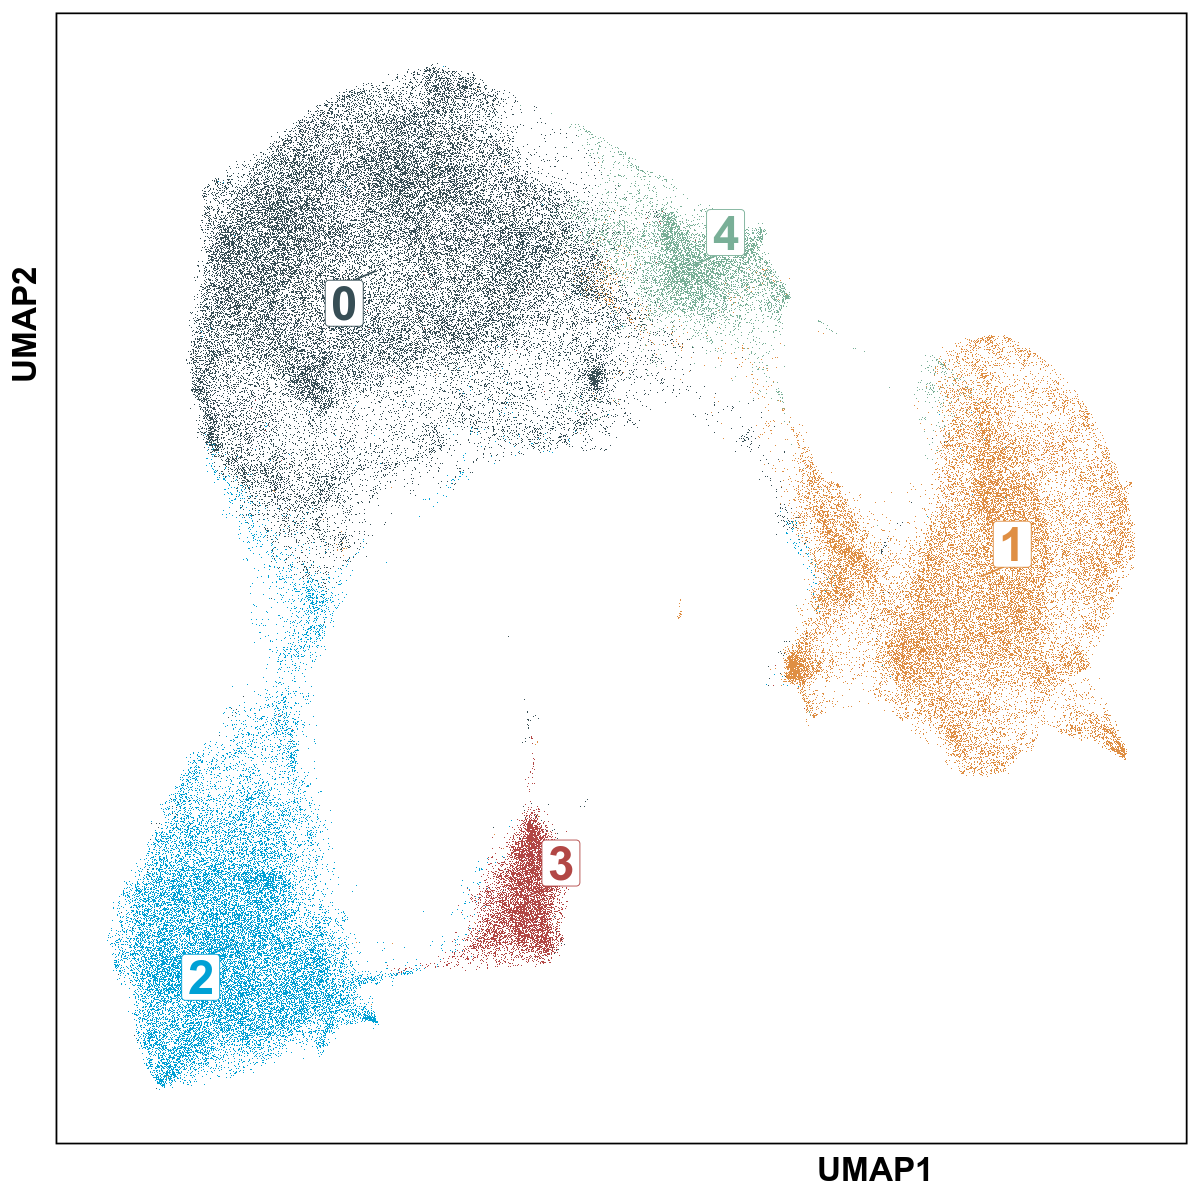

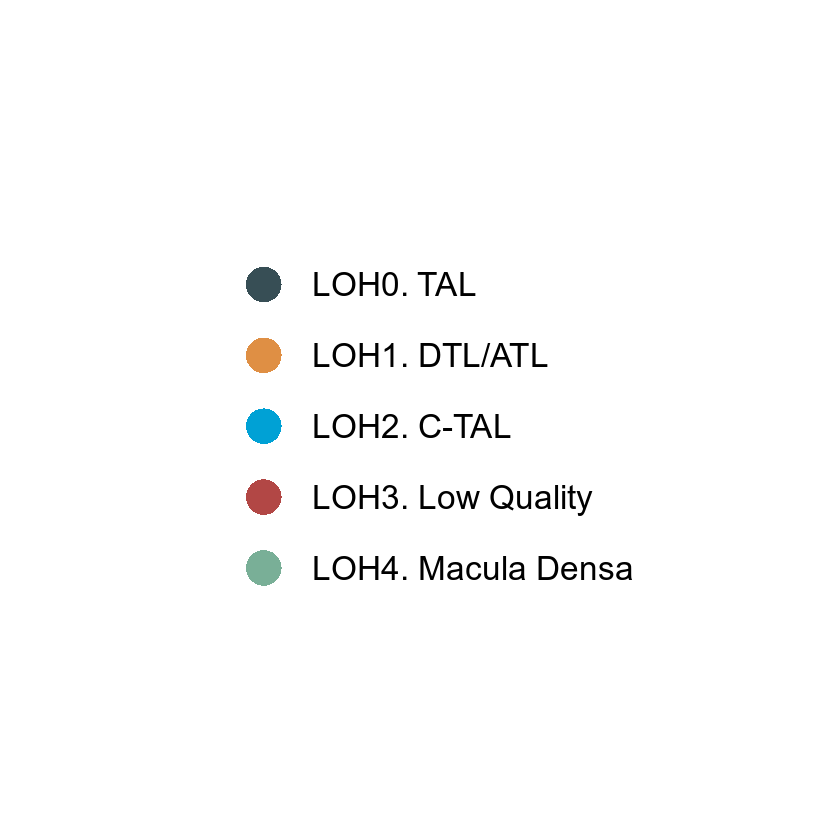

In [8]:
options(warn=-1)
cluster_center <- loh_meta %>%
                  group_by(hres.0.2, final_annotation) %>%
                  summarise_at(vars(huwotUMAP1, huwotUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

options(repr.plot.height = 9, repr.plot.width = 18)
p <- ggplot() +
      geom_point(
       data = loh_meta[sample(nrow(loh_meta)), ] %>% 
      select(huwotUMAP1, huwotUMAP2, final_annotation, hres.0.2) %>% 
              mutate(hres.0.2 = as.factor(hres.0.2)),
        aes(x = huwotUMAP1, y = huwotUMAP2, color = final_annotation),
          size = 0.25, shape = 20, stroke = 0.0001) +
      ggrepel::geom_label_repel(
        data = cluster_center,
        aes(x = huwotUMAP1, y = huwotUMAP2, 
            label = hres.0.2, color = as.factor(final_annotation)),
        size = 10,  fontface = "bold",
        box.padding = unit(0.5, "lines"),
        point.padding = unit(0.01, "lines"),
        show.legend = FALSE
      ) +
    ggsci::scale_color_jama()    +
    theme_classic(base_size = 15) +
      theme(
        legend.position = "right",
            #  plot.title = element_text(hjust = 0.5, 
            #                            size = 18, 
            #                            face = "bold"),
              axis.title = element_text(hjust = 0.75, 
                                        size = 20, 
                                        face = "bold"), 
              axis.text = element_blank(),
              axis.line = element_blank(),
              axis.ticks = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=1),
              legend.text = element_text(size = 20),
              legend.title = element_blank()
          
    ) +
    theme(text=element_text(family="Arial")) + 
        labs(x = "UMAP1", y = "UMAP2") +
        guides(color = guide_legend(ncol = 1, override.aes = list(size = 15)))
legend <- cowplot::get_legend(p)
p <- p + theme(legend.position = "none")
legend <- cowplot::plot_grid(legend)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/figure2/figure2e.png",
       p,
       base_height = 10,
       base_width = 10)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/figure2/figure2e-legend.png",
       legend,
       base_height = 7,
       base_width = 7)
fig.size(10, 10)
p
fig.size(7, 7)
legend
options(warn=0)

In [ ]:
options(repr.plot.height = 8, repr.plot.width = 8)
ggplot() +
  geom_point(
    data=select(loh_meta, c(huwotUMAP1, huwotUMAP2, dataset)),
    aes(x = huwotUMAP1, y = huwotUMAP2),
    size = 0.1, stroke = 0.0001, color = "lightgrey"
  ) + 
  geom_point(
    data=loh_meta %>% filter(dataset == "scRNAseq") %>% select(huwotUMAP1, huwotUMAP2),
    aes(x = huwotUMAP1, y = huwotUMAP2),
    size = 0.1, stroke = 0.0001, color = "coral"
  ) +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
        #  plot.title = element_text(hjust = 0.5, 
        #                            size = 18, 
        #                            face = "bold"),
          axis.title = element_text(hjust = 0.6, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +     labs(x = "UMAP1", y = "UMAP2") 


ggplot() +
  geom_point(
    data=select(loh_meta, c(huwotUMAP1, huwotUMAP2, dataset)),
    aes(x = huwotUMAP1, y = huwotUMAP2),
    size = 0.1, stroke = 0.0001, shape = 20, color = "lightgrey"
  ) + 
  geom_point(
    data=loh_meta %>% filter(dataset == "snRNAseq") %>% select(huwotUMAP1, huwotUMAP2),
    aes(x = huwotUMAP1, y = huwotUMAP2),
    size = 0.1, stroke = 0.0001, shape = 20, color = "deepskyblue"
  ) +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
        #  plot.title = element_text(hjust = 0.5, 
        #                            size = 18, 
        #                            face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +     labs(x = "UMAP1", y = "UMAP2") 

In [ ]:
fig.size(10, 12)
plot_shuffled_features(loh_meta, 
                       norm, 
                       "EGF", pct = 0.95) 

In [ ]:
fig.size(8, 8)

plot_dist <- function(input_df, norm, feature)  {
    plot_df <- input_df %>% mutate(Exp = norm[feature, input_df$cell])
    p <- ggplot(plot_df, aes(x = hres.0.2, y = Exp, fill = dataset)) + 
            geom_violin(scale = "width") + 
            theme_classic(base_size = 20) + 
            labs(x = "Cluster", y = "Normalized Expression", title = feature) +
            theme(plot.title = element_text(size = 25, face = "bold.italic", hjust = 0.5))
    return(p)
}

plot_dist(loh_meta, norm, "CRYAB")
plot_dist(loh_meta, norm, "TACSTD2")

In [ ]:
#SLC14A2, SMOC2
plot_dist(loh_meta, norm, "SLC14A2")
plot_dist(loh_meta, norm, "SMOC2")
#CLCNKA, CLDN10, PROX1
plot_dist(loh_meta, norm, "PROX1")
plot_dist(loh_meta, norm, "AQP1")
plot_dist(loh_meta, norm, "CLDN10")


In [ ]:
ggplot(loh_meta, 
       aes(x = as.factor(hres.0.2), y = as.numeric(doublet_score), fill = dataset)) + 
    geom_boxplot() + theme_classic(base_size = 20) + 
    labs(x = "cluster", y = "scrublet_score")




ggplot(loh_meta, 
       aes(x = as.factor(hres.0.2), y = log(as.numeric(nCount_RNA)), fill = dataset)) + 
    geom_boxplot() + theme_classic(base_size = 20) +
    labs(x = "cluster", y = "log(Counts Per Cell)")




ggplot(loh_meta,
       aes(x = as.factor(hres.0.2), y = log(as.numeric(nFeature_RNA)), fill = dataset)) + 
    geom_boxplot() + theme_classic(base_size = 20) + 
    labs(x = "cluster", y = "log(Genes Per Cell)")

### SC VS SN HEATMAP

In [ ]:
loh_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/loh_meta_qcd_harmony_umap_clusternames_11302023.rds')
loh_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_qcd_norm_12072023.rds')

In [ ]:
sc_meta <- loh_meta %>% filter(dataset == "scRNAseq")
sc_de <- wilcoxauc(loh_norm[, sc_meta$cell], sc_meta$final_annotation)

In [ ]:
sn_meta <- loh_meta %>% filter(dataset == "snRNAseq")
sn_de <- wilcoxauc(loh_norm[, sn_meta$cell], sn_meta$final_annotation)

In [ ]:
genes <- c("CYFIP2", "MFSD4A", "RAP1GAP", 
           "ANK2", "CRYAB", "TACSTD2", 
           "SLC44A5", "TMEM52B", "CLDN16", "WNK1",
           "PAPPA2", "NOS1", "ROBO2")

In [ ]:
sc_plot_df <- sc_de %>%  filter(feature %in% genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 
sn_plot_df <- sn_de %>%  filter(feature %in% genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 

In [ ]:
fig.size(10, 15)
ggplot(sc_plot_df %>% rename(percent = pct_in,
                             zscore = avgExpr_scaled), 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-2, 2), 
                         oob = scales::squish) + 
    scale_x_discrete(limits = genes) + 
    scale_y_discrete(limits = final_annotation$final_annotation) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(face = "bold", size = 15),
          axis.title = element_text(size = 15)) + 
    labs(x = "", y = "")
fig.size(10, 15)
ggplot(sn_plot_df %>% rename(percent = pct_in,
                             zscore = avgExpr_scaled), 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-2, 2), 
                         oob = scales::squish) + 
    scale_x_discrete(limits = genes) + 
    scale_y_discrete(limits = final_annotation$final_annotation) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(face = "bold", size = 15),
          axis.title = element_text(size = 15)) + 
    labs(x = "", y = "")

### SC VS SN FREQ

In [ ]:
loh_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/loh_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [ ]:
loh_meta <- loh_meta  %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3]) 

sample_freq <- loh_meta %>% select(dataset, individual, hres.0.2) %>% 
                    table() %>% data.frame() %>% 
                    pivot_wider(names_from = "hres.0.2", values_from = Freq) 

ind_list <- loh_meta %>% select(dataset, individual) %>% 
                table() %>% data.frame() %>% 
                pivot_wider(names_from = 'dataset', values_from = "Freq") %>% filter(scRNAseq > 200 & snRNAseq > 200) %>% 
                pull(individual)
sample_freq_sc <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "scRNAseq") %>% 
                    select(-dataset) %>% colSums()

sample_freq_sn <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "snRNAseq") %>% 
                    select(-dataset) %>% colSums()
sample_freq <- data.frame(rep("a", 5))
sample_freq$sc_freq <- sample_freq_sc / sum(sample_freq_sc)
sample_freq$sc_se <- sqrt((sample_freq$sc_freq * (1 - sample_freq$sc_freq)) / sample_freq_sc)
sample_freq$sn_freq <- sample_freq_sn / sum(sample_freq_sn)
sample_freq$sn_se <- sqrt((sample_freq$sn_freq * (1 - sample_freq$sn_freq)) / sample_freq_sn)
sample_freq <- sample_freq[,- 1]
sample_freq$hres.0.2 <- as.character(seq(0, 4))

fig.size(8, 8)

max_val <- max(sample_freq[, c("sc_freq", "sn_freq")])

ggplot(sample_freq, aes(x = sc_freq, y = sn_freq, color = hres.0.2)) + 
    geom_abline(linetype = "dashed") +
    ggsci::scale_color_jama()   +
    theme_classic() + 
    geom_point(size = 4) + 
    geom_linerange(aes(ymax = sn_freq+1.96*sn_se, 
                        ymin = sn_freq-1.96*sn_se), alpha = 0.5) +
    geom_linerange(aes(xmax = sc_freq+1.96*sc_se, 
                        xmin = sc_freq-1.96*sc_se), alpha = 0.5) +
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18)) +
    coord_cartesian(xlim = c(0, 0.5), ylim = c(0, 0.5)) + 
    labs(x = "scRNAseq",
         y = "snRNAseq")

In [ ]:
cor.test(sample_freq$sc_freq, sample_freq$sn_freq)

## CASE/CONTROL

In [ ]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])


sc_meta <- loh_meta[, !colnames(loh_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = loh_meta$sample) %>% 
                        filter(dataset == 'scRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

sn_meta <- loh_meta[, !colnames(loh_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = loh_meta$sample) %>% 
                        filter(dataset == 'snRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = loh_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
  theme(
   # legend.position = "bottom",
   # legend.key.width = unit(1, 'cm'),
    legend.position  = "none",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r")


pos_fdr_thresh <- fdr
neg_fdr_thresh <- -1 * fdr


interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)

cluster_order <- meta %>% 
                    select(ncorr, final_annotation) %>% 
                    group_by(final_annotation) %>% 
                    summarize(avg = mean(ncorr)) %>% 
                    arrange(desc(avg)) %>% pull(final_annotation)


ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = cluster_order) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
subset <- c('LOH0. TAL', 
            'LOH2. C-TAL', 
            'LOH1. DTL/ATL',
            'LOH4. Macula Densa')

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = subset) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 25, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sn_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sn_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sn_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sn_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = loh_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
  theme(
   # legend.position = "bottom",
   # legend.key.width = unit(1, 'cm'),
    legend.position  = "none",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r")


pos_fdr_thresh <- fdr
neg_fdr_thresh <- -1 * fdr


interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)

cluster_order <- meta %>% 
                    select(ncorr, final_annotation) %>% 
                    group_by(final_annotation) %>% 
                    summarize(avg = mean(ncorr)) %>% 
                    arrange(desc(avg)) %>% pull(final_annotation)


ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = cluster_order) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
subset <- c('LOH0. TAL', 
            'LOH2. C-TAL', 
            'LOH1. DTL/ATL',
            'LOH4. Macula Densa')

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = subset) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 25, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [47]:
sc_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_meta.csv')
sc_ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sc_ncorr.csv", header = FALSE)
sc_meta$ncorr <- sc_ncorr$V1
sn_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sn_meta.csv')
sn_ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/case_control/sn_ncorr.csv", header = FALSE)
sn_meta$ncorr <- sn_ncorr$V1

final_annotation <- data.frame(hres.0.2 = as.factor(seq(0, 4)),
                               final_annotation = c('LOH0. TAL',
                                                    'LOH1. DTL/ATL',
                                                    'LOH2. C-TAL',
                                                    'LOH3. Low Quality',
                                                    'LOH4. Macula Densa'))

sc_meta <- left_join(sc_meta, final_annotation) %>% mutate(new_cluster_number = hres.0.2)
sn_meta <- left_join(sn_meta, final_annotation) %>% mutate(new_cluster_number = hres.0.2)

sc_summary <- sc_meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(sc.ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
sn_summary <-  sn_meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(sn.ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
summary <- sc_summary %>% left_join(sn_summary)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/loh_casecontrol_corr_04152024.csv', 
              quote = FALSE, row.names = FALSE, sep = "\t")

Joining, by = "final_annotation"
Joining, by = "final_annotation"
Joining, by = "new_cluster_number"


### DE

In [ ]:
loh_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/loh_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [ ]:
loh_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/loh_meta_qcd_harmony_umap_clusternames_11302023.rds')
loh_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_qcd_norm_12072023.rds')

In [ ]:
out <- mclapply(unique(loh_meta$sample), pseudobulk, loh_meta, loh_norm,
               mc.cores = 6)

In [ ]:
loh_pb <- data.frame(do.call(rbind, out))
sample_stats <- loh_meta %>% group_by(sample) %>% summarize(avg_count = mean(nCount_RNA), avg_mt = mean(percent.mt))
loh_pb <- loh_pb %>% left_join(sample_stats) %>% left_join(unique(loh_meta %>% select(sample, Type)))
loh_pb <- loh_pb[grep("cells", loh_pb$sample), ]
colnames(loh_pb)[1:36601] <- rownames(loh_norm)

In [ ]:
saveRDS(loh_pb, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_norm_pseudobulk_12072023.rds')

In [ ]:
loh_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_norm_pseudobulk_12072023.rds')

In [ ]:
de <- function(feature, df) {
    model_df <- df %>% select(feature, sample, Type, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.10 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Type, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['TypeLN', 'Estimate']
        SE <- summary(m_1)$coefficients['TypeLN', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

In [ ]:
de_out <- mclapply(colnames(loh_pb)[1:36601], de, loh_pb, mc.cores = 20)

In [ ]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [ ]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_case_control_differential_expression_120722023.rds')

In [ ]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_case_control_differential_expression_120722023.rds')

In [ ]:
de_df <- de_df %>% na.omit()

In [ ]:
genes <- c("IFI6", "BST2", "BBOX1", "WFDC2", "IFITM3", "PDK4", "FKBP5", "ZBTB16", "EGF", "NFKBIA")

In [ ]:
fig.size(6, 6)
ggplot(de_df,
                aes(x = Beta, y = -log10(LRP))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(LRP < 0.05/nrow(de_df) & abs(Beta) >= 0.3,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(LRP)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(LRP)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.3, 0.3), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05/nrow(de_df)), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(LRP < 0.05/nrow(de_df) & abs(Beta) >= 0.3 | 
                                                           gene %in% genes, gene, NA),
                                            label_size = ifelse(gene %in% genes, 6 , 3)),
                                     aes(x = Beta, y = -log10(LRP), 
                                         size = label_size, label = label)
            , color = "black") +
    scale_size_identity() + 
    labs(x = "Case/Control Beta", y = "-log10(P value)", title = "LOH")

## WITHIN CASES

In [2]:
loh_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/loh_meta_qcd_harmony_umap_clusternames_11302023.rds')

clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% 
                        rename(Final_Site = Site) %>% select(-sample)

first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])


sc_meta <- loh_meta %>% filter(dataset == 'scRNAseq', Type == "LN") %>% 
                        select(- colnames(loh_meta)[colnames(loh_meta) %in% colnames(clinical)]) %>% 
                        mutate(individual = str_split(sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

sn_meta <- loh_meta %>% filter(dataset == 'snRNAseq', Type == "LN") %>% 
                        select(- colnames(loh_meta)[colnames(loh_meta) %in% colnames(clinical)]) %>% 
                        mutate(individual = str_split(sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

Joining, by = "individual"
Joining, by = "individual"
Joining, by = "individual"
Joining, by = "individual"


## AGE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_meta_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_harmony_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_umap_age.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_meta_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_harmony_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_umap_age.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_meta_age.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_umap_age.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_age_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_age_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(ncorr) > fdr_10, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = dn_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', alpha = 0.1) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation)) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "Neighborhood Correlation: p = 0.0338") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

## SEX

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_meta_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_harmony_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_umap_sex.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")
write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_meta_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_harmony_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_umap_sex.csv', 
          row.names = FALSE, quote = FALSE)

## RESPONSE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")




write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_meta_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_harmony_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_umap_response.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

sc_pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/sc_injured_pt_prop_07142023.rds')

meta <- left_join(meta, sc_pt_meta)



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_meta_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_harmony_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_umap_response.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

In [ ]:
pt_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_meta_response.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_umap_response.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_injured_pt_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_injured_pt_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
pt_meta$ncorr <- ncorr$V1


meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_meta_response.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_umap_response.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_response_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_response_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

chron_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_covariate_cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_covariate_cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
chron_meta$ncorr <- ncorr$V1

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_meta_response.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_umap_response.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_response_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_response_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1


fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = loh_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', 
                        size = 0.75, stroke = 0.00001) +  
      geom_point(data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.00001) +  
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "LOH Response Status: p = 0.0289") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

In [ ]:
ncorr_meta <- pt_meta %>% 
                    select(cell, ncorr) %>% 
                    rename(pt_ncorr = ncorr) %>% 
                left_join(meta %>% 
                            select(cell, ncorr) %>% 
                            rename(chronicity_ncorr = ncorr)) %>% na.omit()

get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

ncorr_meta$density <- get_density(ncorr_meta$pt_ncorr, ncorr_meta$chronicity_ncorr)

fig.size(10, 10)
cor(ncorr_meta$pt_ncorr, ncorr_meta$chronicity_ncorr)
ggplot(ncorr_meta, aes(x = pt_ncorr, y = chronicity_ncorr, color = density)) +
    geom_point() +
    scale_color_viridis(option = "magma") + 
    theme_classic(base_size = 20) +
    geom_abline(slope = -1, linetype = 'dashed', linewidth = 2) + 
    scale_x_continuous(limits = c(-0.65, 0.65)) + 
    scale_y_continuous(limits = c(-0.3, 0.3)) + 
    labs(x = "Injured PT CNA correlation",
         y = "Response CNA correlation",
         title = "LOH: R = -0.944") + 
    theme(
          axis.text = element_text(face = "bold"),
          axis.title = element_text(face = "bold"),
          plot.title = element_text(face = "bold.italic", 
                                    hjust = 0.5))

In [ ]:
ncorr_meta <- chron_meta %>% 
                    select(cell, ncorr) %>% 
                    rename(chron_ncorr = ncorr) %>% 
                left_join(meta %>% 
                            select(cell, ncorr) %>% 
                            rename(response_ncorr = ncorr)) %>% na.omit()

get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

ncorr_meta$density <- get_density(ncorr_meta$response_ncorr, ncorr_meta$chron_ncorr)

fig.size(10, 10)
cor(ncorr_meta$response_ncorr, ncorr_meta$chron_ncorr)
ggplot(ncorr_meta, aes(x = response_ncorr, y = chron_ncorr, color = density)) +
    geom_point() +
    scale_color_viridis(option = "magma") + 
    theme_classic(base_size = 20) +
    geom_smooth(method = "lm") + 
    scale_x_continuous(limits = c(-0.65, 0.65)) + 
    scale_y_continuous(limits = c(-0.3, 0.3)) + 
    labs(x = "Response CNA correlation",
         y = "Chronicity CNA correlation",
         title = "R = -0.939") + 
    theme(
          axis.text = element_text(face = "bold"),
          axis.title = element_text(face = "bold"),
          plot.title = element_text(face = "bold.italic", 
                                    hjust = 0.5))

## RACE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_meta_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_harmony_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sn_umap_race.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_meta_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_harmony_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/age_sex_response_race/sc_umap_race.csv', 
          row.names = FALSE, quote = FALSE)

## FIRST BIOPSY

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sn_meta_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sn_harmony_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sn_umap_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sc_meta_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sc_harmony_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sc_umap_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)

## PRED USE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sn_meta_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sn_harmony_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sn_umap_preduse.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sc_meta_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sc_harmony_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sc_umap_preduse.csv', 
          row.names = FALSE, quote = FALSE)

## SITE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sn_meta_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sn_harmony_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sn_umap_site.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sc_meta_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sc_harmony_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/first_biop_pred_use_site/sc_umap_site.csv', 
          row.names = FALSE, quote = FALSE)

## CHRONICITY

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

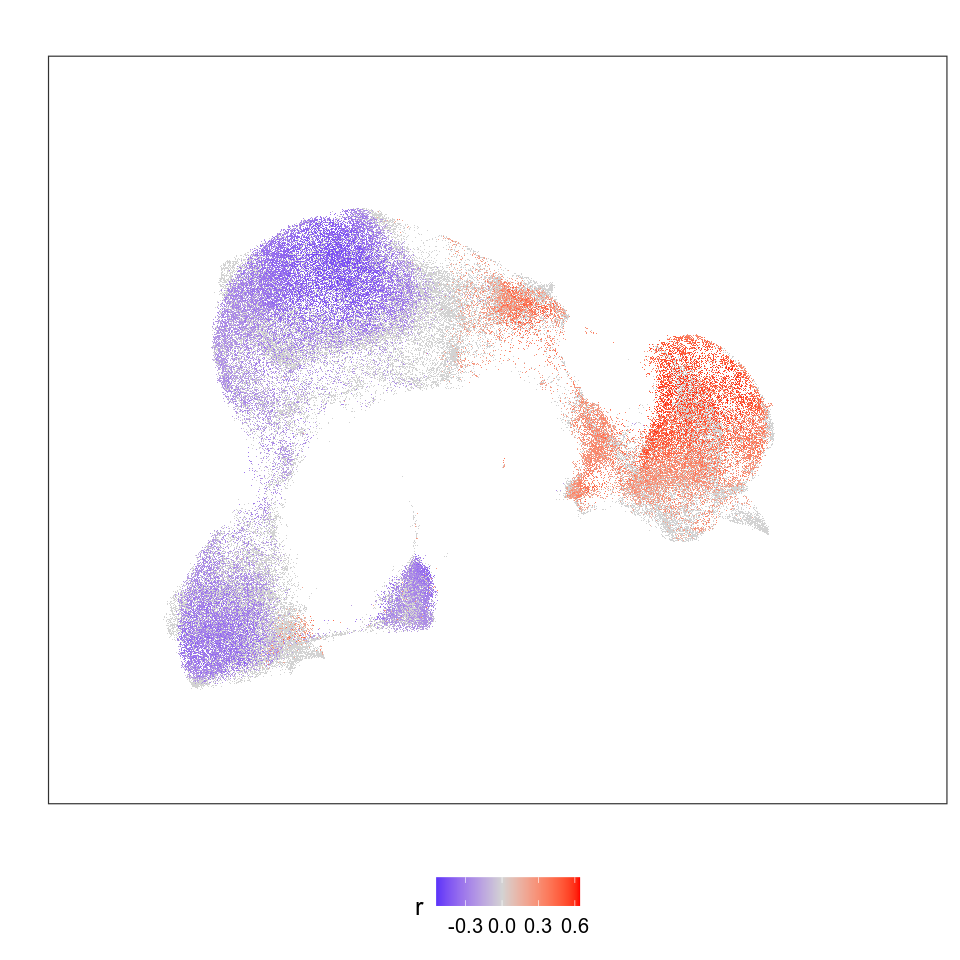

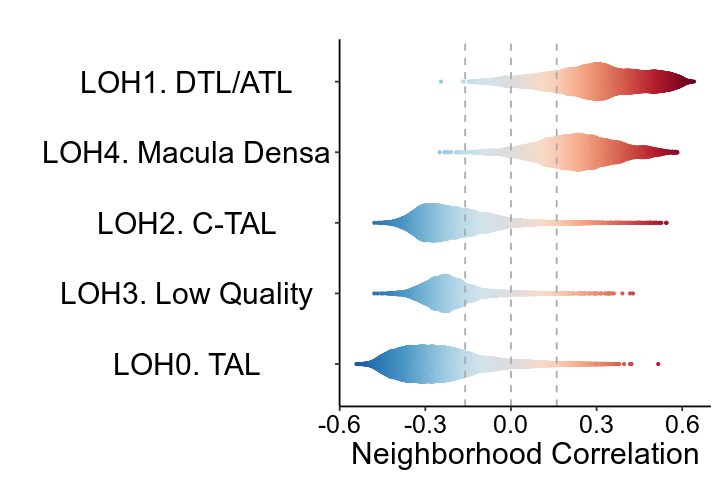

In [39]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_conditional_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_conditional_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_5 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_5, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = loh_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey',
                    size = 0.1, shape = 20, stroke = 0.0001) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation),
          size = 0.1, shape = 20, stroke = 0.0001
) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="", y="", title = "", color = "r") +
      theme_bw(base_size = 15) +
  theme( legend.position = "bottom",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) +
    scale_x_continuous(limits = c(-8, 12)) +
    scale_y_continuous(limits = c(-8, 8))

pos_fdr_thresh <- fdr_5
neg_fdr_thresh <- -1 * fdr_5

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(4, 6)

cluster_order <- meta %>% select(final_annotation, ncorr) %>% 
                    group_by(final_annotation) %>% summarize(ncorr = mean(ncorr)) %>% 
                    arrange(ncorr) %>% pull(final_annotation)

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

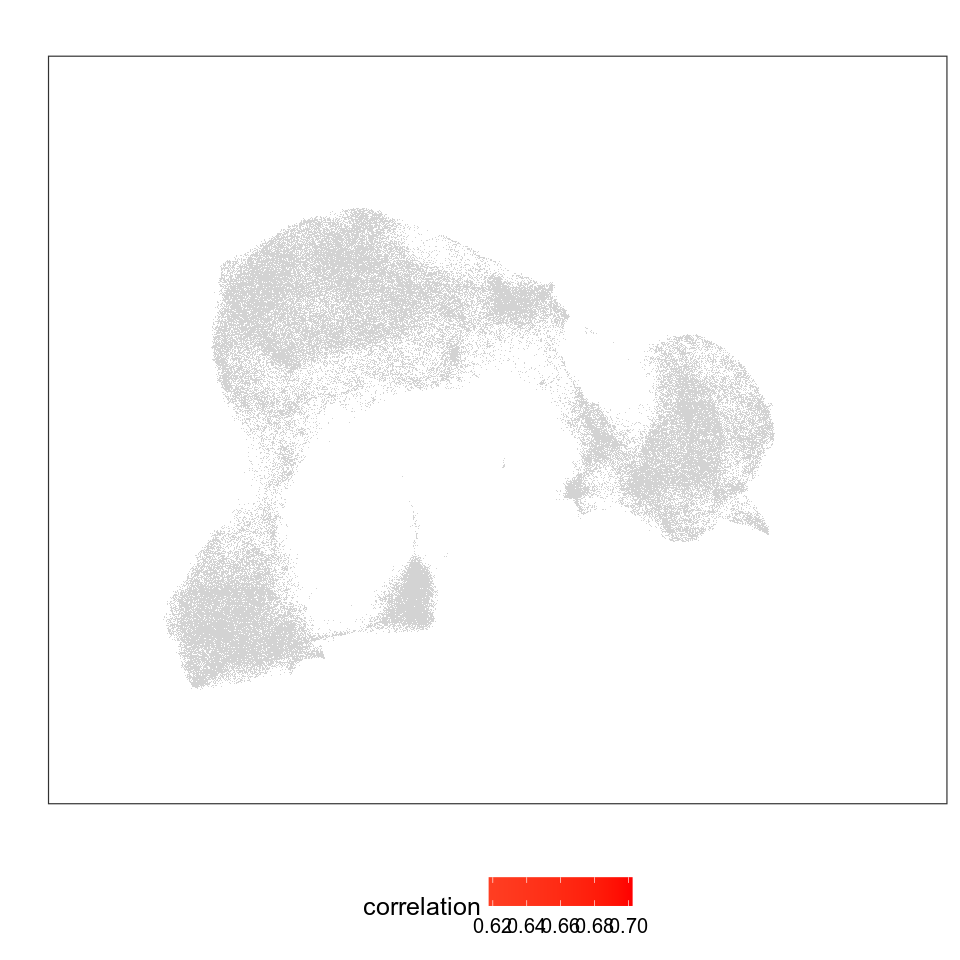

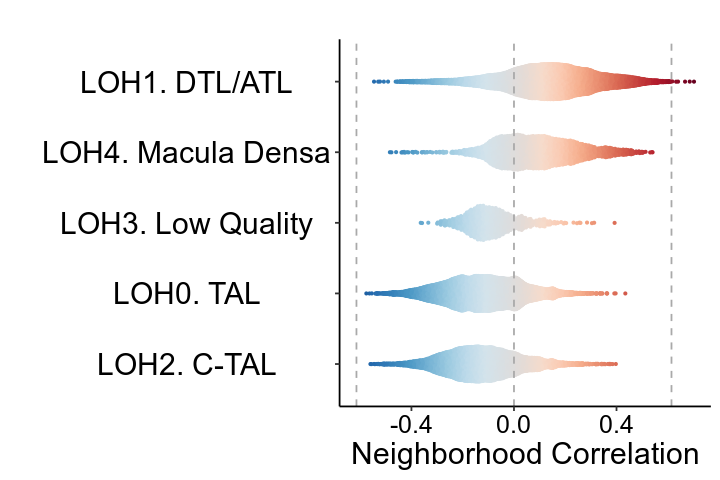

In [41]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sn_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sn_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sn_conditional_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sn_conditional_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_5 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_5, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = loh_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey',
                    size = 0.1, shape = 20, stroke = 0.0001) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation),
          size = 0.1, shape = 20, stroke = 0.0001
) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="", y="", title = "") +
      theme_bw(base_size = 15) +
  theme( legend.position = "bottom",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) +
    scale_x_continuous(limits = c(-8, 12)) +
    scale_y_continuous(limits = c(-8, 8))

pos_fdr_thresh <- fdr_5
neg_fdr_thresh <- -1 * fdr_5

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(4, 6)

cluster_order <- meta %>% select(final_annotation, ncorr) %>% 
                    group_by(final_annotation) %>% summarize(ncorr = mean(ncorr)) %>% 
                    arrange(ncorr) %>% pull(final_annotation)

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [56]:
sc_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_meta.csv')
sc_ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_conditional_ncorr.csv", header = FALSE)
sc_meta$ncorr <- sc_ncorr$V1
sn_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sn_meta.csv')
sn_ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sn_conditional_ncorr.csv", header = FALSE)
sn_meta$ncorr <- sn_ncorr$V1

final_annotation <- data.frame(hres.0.2 = as.factor(seq(0, 4)),
                               final_annotation = c('LOH0. TAL',
                                                    'LOH1. DTL/ATL',
                                                    'LOH2. C-TAL',
                                                    'LOH3. Low Quality',
                                                    'LOH4. Macula Densa'))

sc_meta <- left_join(sc_meta, final_annotation) %>% mutate(new_cluster_number = hres.0.2)
sn_meta <- left_join(sn_meta, final_annotation) %>% mutate(new_cluster_number = hres.0.2)

sc_summary <- sc_meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(sc.ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
sn_summary <-  sn_meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(sn.ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
summary <- sc_summary %>% left_join(sn_summary)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/loh_chronicity_corr_04152024.csv', 
              quote = FALSE, row.names = FALSE, sep = "\t")

Joining, by = "final_annotation"
Joining, by = "final_annotation"
Joining, by = "new_cluster_number"


### DE

In [31]:
de <- function(feature, df) {
    model_df <- df %>% select(feature, sample, First_biop, Responder_Status, 
                              Final_Chronicity, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.05 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Final_Chronicity, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['Final_Chronicity', 'Estimate']
        SE <- summary(m_1)$coefficients['Final_Chronicity', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

In [33]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_meta.csv')
loh_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_norm_pseudobulk_12072023.rds')

In [34]:
loh_pb <- loh_pb %>% 
                filter(sample %in% unique(meta$sample)) %>% 
                left_join(meta %>% 
                              select(sample, First_biop, Responder_Status, Final_Chronicity) %>% 
                              unique())

Joining, by = "sample"


In [35]:
de_out <- mclapply(colnames(loh_pb)[1:36601], de, loh_pb, mc.cores = 20)

In [36]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [37]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_chronicity_differential_expression_03082024.rds')

In [38]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_chronicity_differential_expression_03082024.rds')

In [40]:
de_df <- de_df %>% 
            na.omit() %>% 
            arrange(LRP) %>% 
            mutate(FDR = p.adjust(LRP, method = "BH")) 

In [48]:
genes <- c("ANXA2", "MMP7", "WFDC2", "SPP1", "TIMP1", "LGALS3", "AGR2",
           "EGF", "UMOD", "IDH2", "SLC12A1", "SERPINA5", "IFI6")

Warning message:
“Removed 27227 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


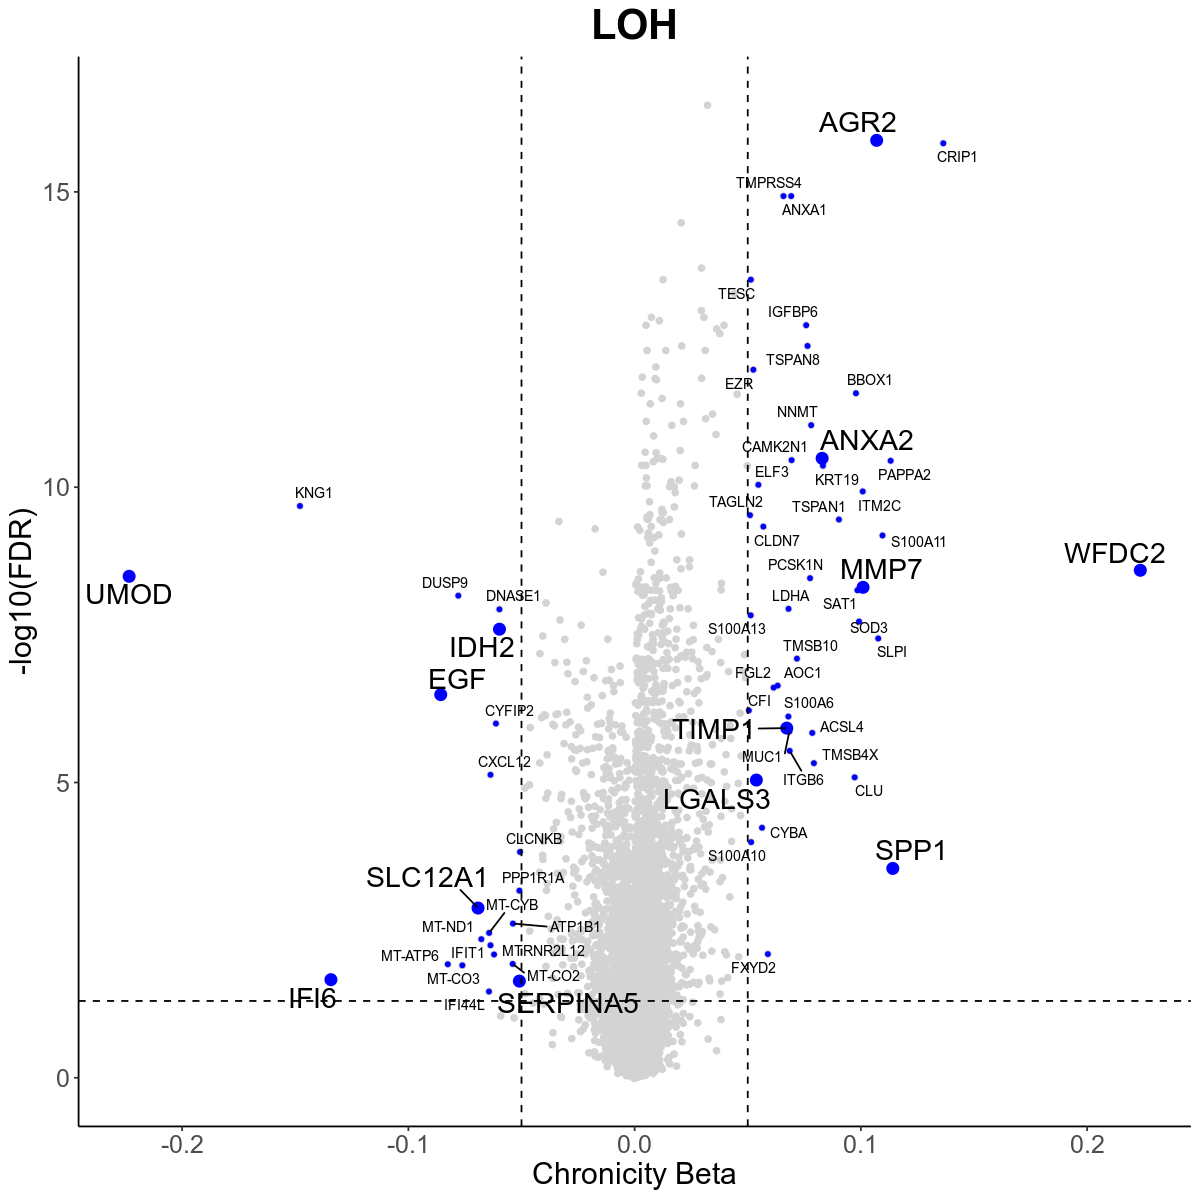

In [49]:
fig.size(10, 10)
ggplot(de_df,
                aes(x = Beta, y = -log10(FDR))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(FDR < 0.05 & abs(Beta) >= 0.05,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.05, 0.05), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(FDR < 0.05 & abs(Beta) >= 0.05 | 
                                                           gene %in% genes, gene, NA),
                                            label_size = ifelse(gene %in% genes, 6 , 3)),
                                     aes(x = Beta, y = -log10(FDR), 
                                         size = label_size, label = label)
            , color = "black") +
    scale_size_identity() + 
    labs(x = "Chronicity Beta", y = "-log10(FDR)", title = "LOH")

## ACTIVITY

In [7]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Activity)]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [8]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))

harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Activity)]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RESULTS

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sc_chronicity_cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sc_chronicity_cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = loh_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', alpha = 0.1) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation)) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "Neighborhood Correlation: p = 9.99e-05") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

cluster_order <- meta %>% select(cluster_names, ncorr) %>% group_by(cluster_names) %>% summarize(ncorr = mean(ncorr)) %>% arrange(ncorr) %>% pull(cluster_names)

ggplot(meta, 
           aes(x = reorder(cluster_names, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_x_discrete(limits = cluster_order) + 
    labs( x= "", y = "Neighborhood correlation") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sn_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sn_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sn_chronicity_cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/activity/sn_chronicity_cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = loh_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', alpha = 0.1) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation)) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "Neighborhood Correlation: p = 9.99e-05") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)


ggplot(meta, 
           aes(x = reorder(cluster_names, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_x_discrete(limits = cluster_order) + 
    labs( x= "", y = "Neighborhood correlation") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

In [ ]:
fdrs %>% filter(fdr < 0.2)

## ISN

In [28]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/ISN/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/ISN/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/ISN/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [29]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/ISN/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/ISN/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/ISN/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## % INJURED PT

In [3]:
lateinjury_high_prop <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_highprop_singlecell_05102024.rds') %>% 
                    select(Prop, sample)

In [4]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

meta <- meta %>% left_join(lateinjury_high_prop %>% rename(injured_pt_prop = Prop))

ind <- c(1:nrow(meta))[!is.na(meta$injured_pt_prop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)


meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "sample"
Joining, by = "Responder.Status"


In [5]:
lateinjury_high_prop <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_highprop_singlenuc_05102024.rds') %>% 
                    select(Prop, sample)

In [6]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

meta <- meta %>% left_join(lateinjury_high_prop %>% rename(injured_pt_prop = Prop))


ind <- c(1:nrow(meta))[!is.na(meta$injured_pt_prop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)


meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "sample"
Joining, by = "Responder.Status"


### RESULTS

In [2]:
pt_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
pt_meta$ncorr <- ncorr$V1

meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_conditional_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/chronicity/sc_conditional_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

In [3]:
ncorr_meta <- pt_meta %>% 
                    select(cell, ncorr) %>% 
                    rename(pt_ncorr = ncorr) %>% 
                left_join(meta %>% 
                            select(cell, ncorr) %>% 
                            rename(chronicity_ncorr = ncorr)) %>% na.omit()

Joining, by = "cell"


[1] 0.7130656

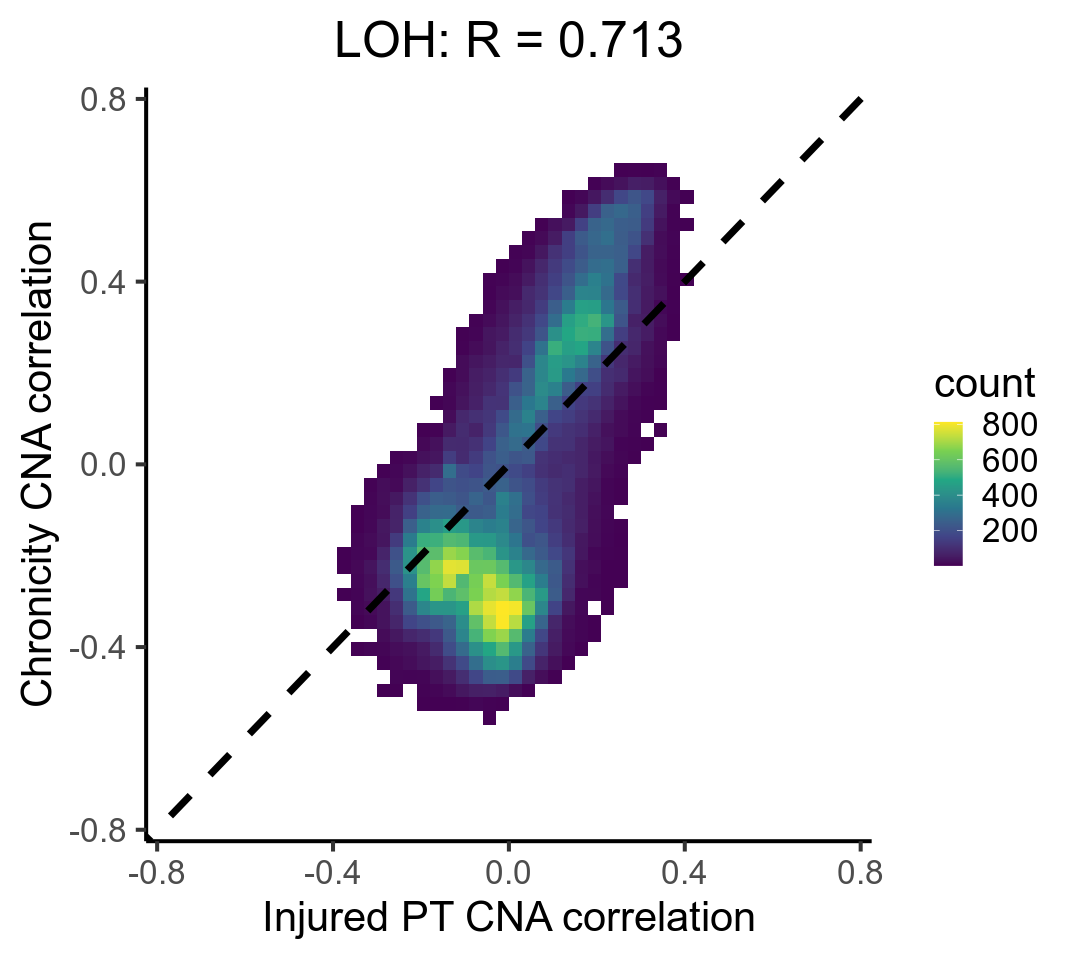

In [ ]:
fig.size(8, 9)
cor(ncorr_meta$pt_ncorr, ncorr_meta$chronicity_ncorr)
cor_plot <- ggplot(ncorr_meta, aes(x = pt_ncorr, y = chronicity_ncorr)) +
                    geom_bin2d(bins = 50) +
                    scale_fill_continuous(type = "viridis",
                                          breaks = c(200, 400, 600, 800)) +
                   theme_classic(base_size = 25) +
                    geom_abline(linetype = 'dashed', linewidth = 2) + 
                    scale_x_continuous(limits = c(-0.75, 0.75)) + 
                    scale_y_continuous(limits = c(-0.75, 0.75)) + 
                    labs(x = "Injured PT CNA correlation",
                         y = "Chronicity CNA correlation",
                         title = "LOH: R = 0.713") + 
                    theme(
                          plot.title = element_text(size = 30, 
                                                    hjust = 0.5),
                            text=element_text(family="Arial"))
cor_plot
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure6/figure6h.png",
       cor_plot,
       base_height = 8,
       base_width = 9)

### CNA

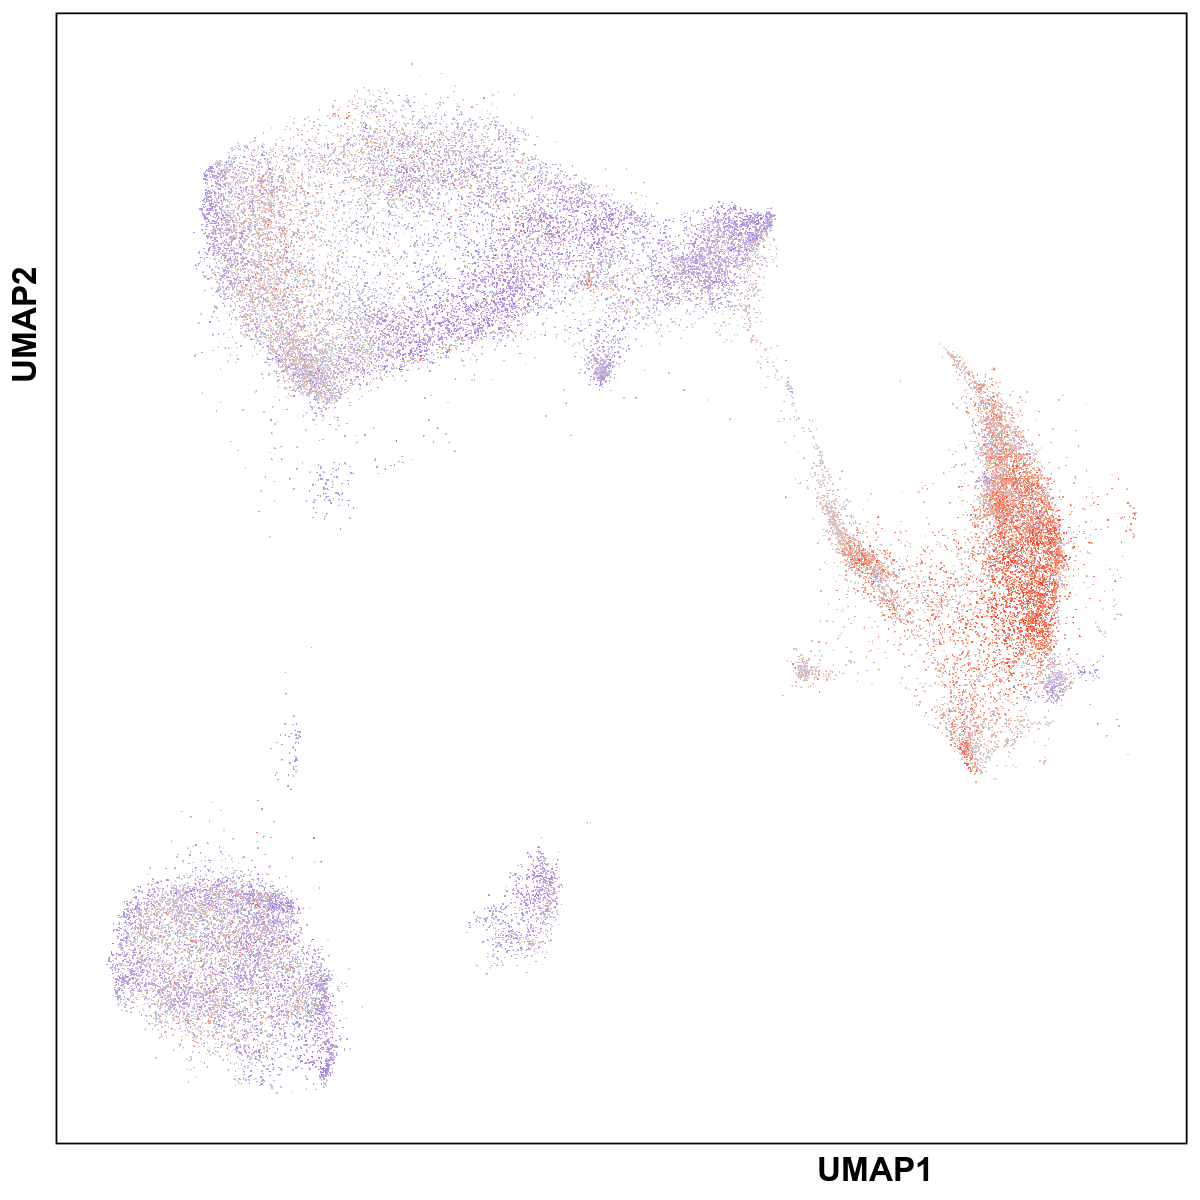

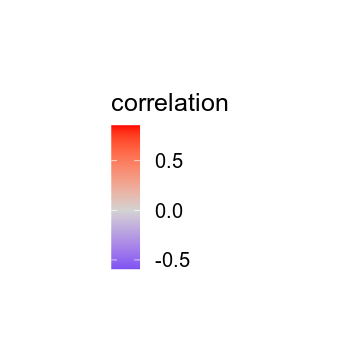

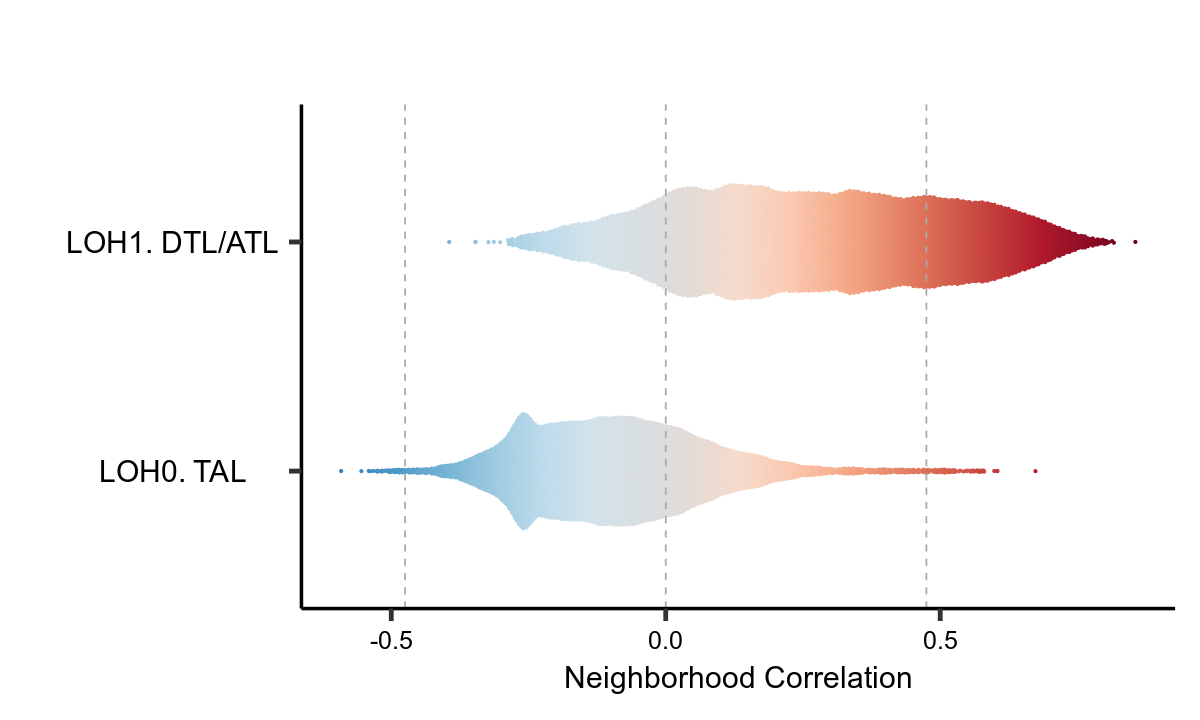

In [14]:
options(warn=-1)
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sn_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sn_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sn_cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sn_cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1


fdr <- fdrs %>% 
            filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
cna_umap <- ggplot() + 
      geom_point(data = tmp_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
      theme(
        legend.position = "right",
            #  plot.title = element_text(hjust = 0.5, 
            #                            size = 18, 
            #                            face = "bold"),
              axis.title = element_text(hjust = 0.75, 
                                        size = 20, 
                                        face = "bold"), 
              axis.text = element_blank(),
              axis.line = element_blank(),
              axis.ticks = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=1)
    ) +
        labs(x = "UMAP1", y = "UMAP2") + 
    theme(text=element_text(family="Arial")) 
umap_legend <- cowplot::get_legend(cna_umap)
cna_umap <- cna_umap + theme(legend.position = "none")
umap_legend <- cowplot::plot_grid(umap_legend)
fig.size(10, 10)
cna_umap
fig.size(3, 3)
umap_legend

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/supplemental_figures/figure10/figure10d-cna_umap.png",
       cna_umap,
       base_height = 10,
       base_width = 10)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/supplemental_figures/figure10/figure10d-cna_umap_legend.png",
       umap_legend,
       base_height = 3,
       base_width = 3)
options(warn=0)

pos_fdr_thresh <- fdr
neg_fdr_thresh <- -1 * fdr

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))
myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))


violin_plot <- ggplot(meta %>% 
                      filter(final_annotation %in% c('LOH1. DTL/ATL',
                                                     'LOH0. TAL')),
                      aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
                    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
                    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
                    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
                    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
                    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
                    labs( x= "Neighborhood Correlation", y = "", title = "") +
                    theme_classic(base_size = 30) +
                    theme(text=element_text(family="Arial"),
                        legend.position = "none",
                        panel.grid = element_blank(),
                        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
                        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
                        axis.title = element_text(size=18, hjust = 0.5),
                        axis.line.x.bottom = element_line(color = 'black', linewidth = 1),
                        axis.line.y.left   = element_line(color = 'black', linewidth = 1))
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/supplemental_figures/figure10/figure10d-violin_plot.png",
       violin_plot,
       base_height = 6,
       base_width = 10)
fig.size(6, 10)
violin_plot

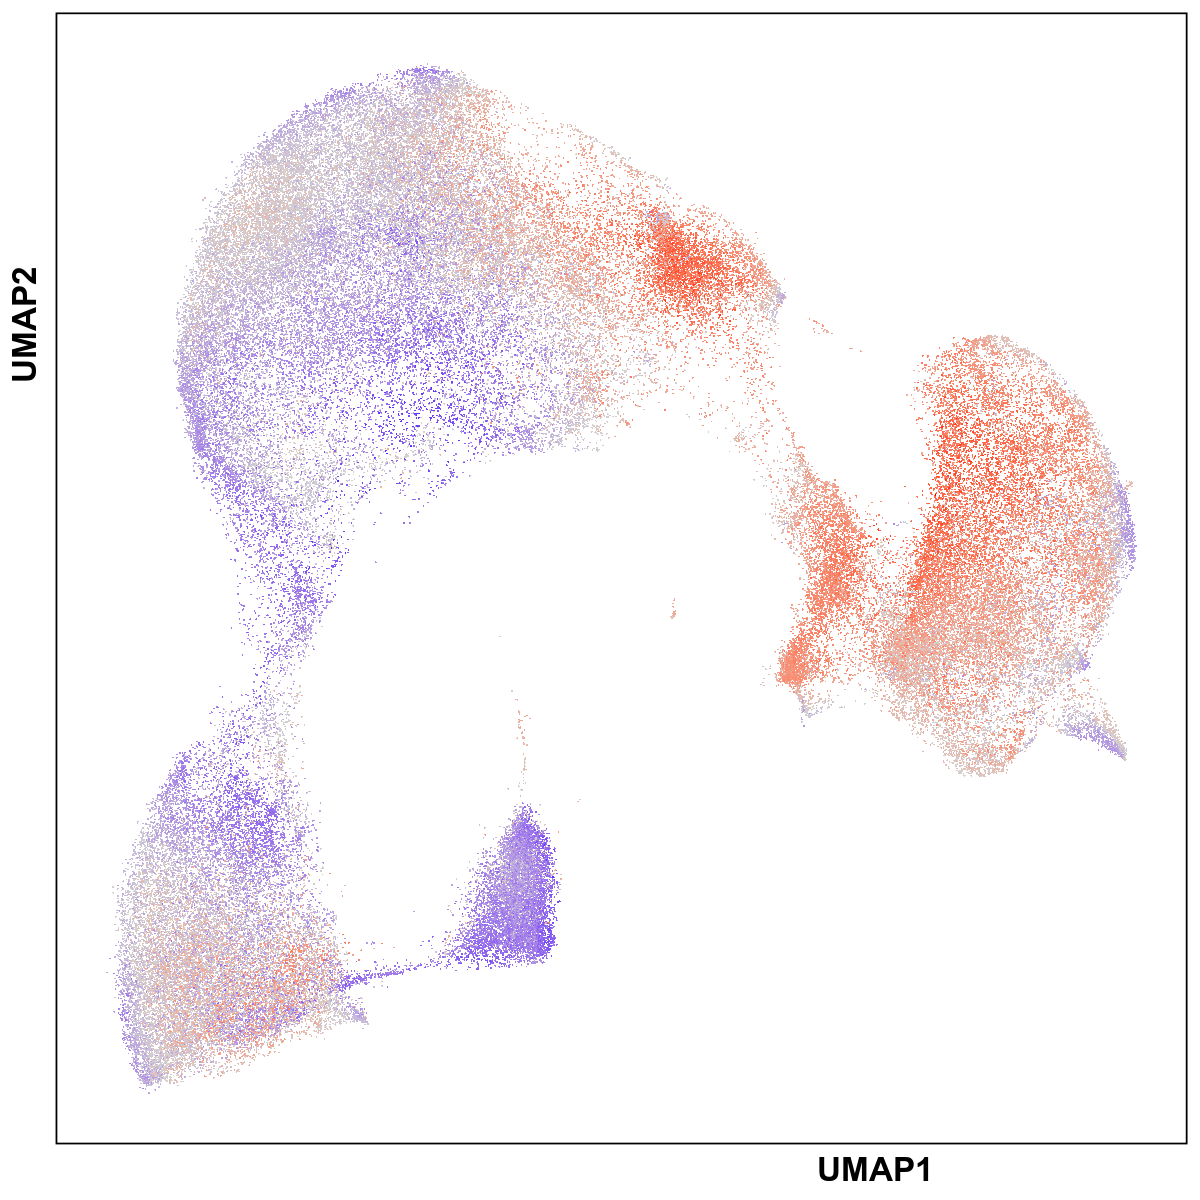

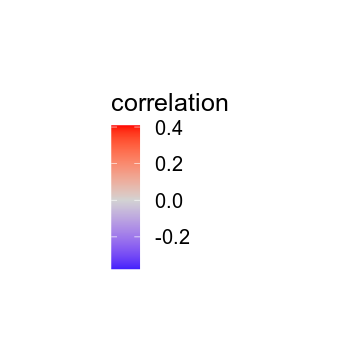

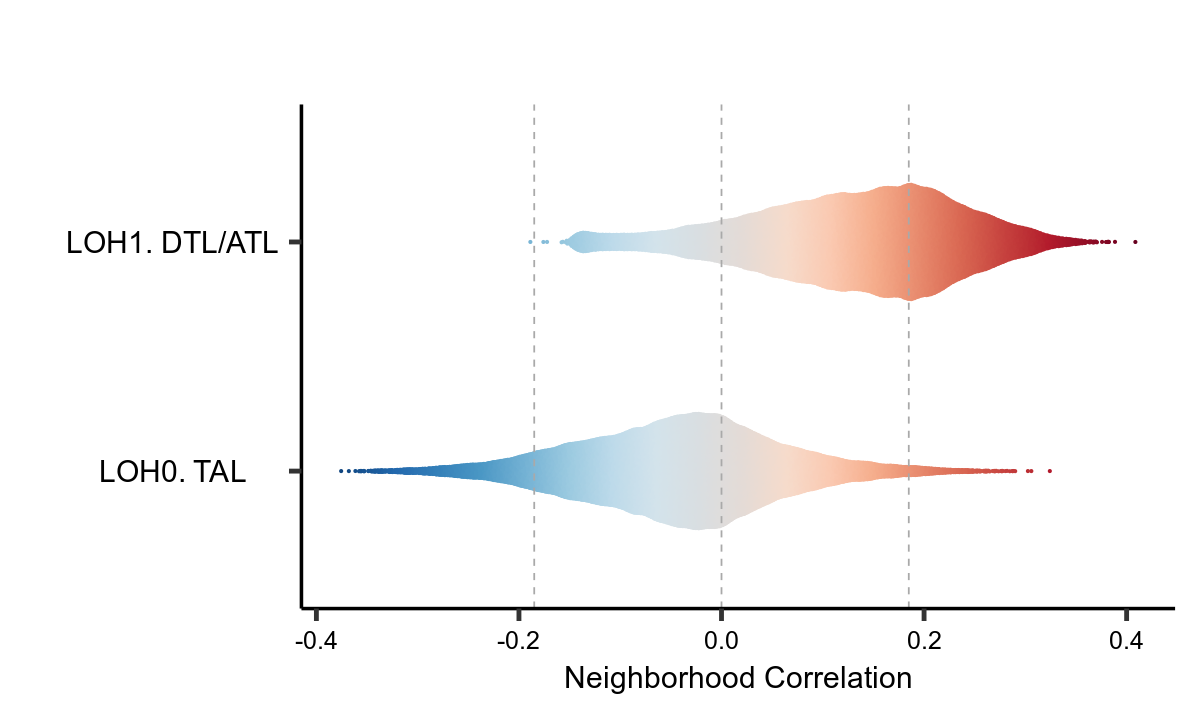

In [15]:
options(warn=-1)
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1


fdr <- fdrs %>% 
            filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
cna_umap <- ggplot() + 
      geom_point(data = tmp_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
      theme(
        legend.position = "right",
            #  plot.title = element_text(hjust = 0.5, 
            #                            size = 18, 
            #                            face = "bold"),
              axis.title = element_text(hjust = 0.75, 
                                        size = 20, 
                                        face = "bold"), 
              axis.text = element_blank(),
              axis.line = element_blank(),
              axis.ticks = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=1)
    ) +
        labs(x = "UMAP1", y = "UMAP2") + 
    theme(text=element_text(family="Arial")) 
umap_legend <- cowplot::get_legend(cna_umap)
cna_umap <- cna_umap + theme(legend.position = "none")
umap_legend <- cowplot::plot_grid(umap_legend)
fig.size(10, 10)
cna_umap
fig.size(3, 3)
umap_legend

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure6/figure6g-cna_umap.png",
       cna_umap,
       base_height = 10,
       base_width = 10)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure6/figure6g-cna_umap_legend.png",
       umap_legend,
       base_height = 3,
       base_width = 3)
options(warn=0)


pos_fdr_thresh <- fdr
neg_fdr_thresh <- -1 * fdr

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))
myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))


violin_plot <- ggplot(meta %>% 
                      filter(final_annotation %in% c('LOH1. DTL/ATL',
                                                     'LOH0. TAL')),
                      aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
                    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
                    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
                    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
                    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
                    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
                    labs( x= "Neighborhood Correlation", y = "", title = "") +
                    theme_classic(base_size = 30) +
                    theme(text=element_text(family="Arial"),
                        legend.position = "none",
                        panel.grid = element_blank(),
                        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
                        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
                        axis.title = element_text(size=18, hjust = 0.5),
                        axis.line.x.bottom = element_line(color = 'black', linewidth = 1),
                        axis.line.y.left   = element_line(color = 'black', linewidth = 1))
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/main_figures/figure6/figure6g-violin_plot.png",
       violin_plot,
       base_height = 6,
       base_width = 10)
fig.size(6, 10)
violin_plot

### DE

In [4]:
de <- function(feature, df) {
    model_df <- df %>% select(feature, sample,  
                              injured_pt_prop, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.1 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + injured_pt_prop, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['injured_pt_prop', 'Estimate']
        SE <- summary(m_1)$coefficients['injured_pt_prop', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

In [5]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/LOH/injured_pt/sc_meta.csv')
loh_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_norm_pseudobulk_12072023.rds')

In [6]:
loh_pb <- loh_pb %>% 
                filter(sample %in% unique(meta$sample)) %>% 
                left_join(meta %>% 
                              select(sample, First_biop, Responder_Status, injured_pt_prop) %>% 
                              unique())

Joining, by = "sample"


In [7]:
de_out <- mclapply(colnames(loh_pb)[1:36601], de, loh_pb, mc.cores = 20)

In [8]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [9]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_injured_pt_differential_expression_08102024.rds')

In [10]:
de_df <- de_df %>% 
            na.omit() %>% 
            arrange(LRP) %>% 
            mutate(FDR = p.adjust(LRP, method = "BH")) 

Warning message:
“Removed 25686 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 25686 rows containing missing values (`geom_text_repel()`).”


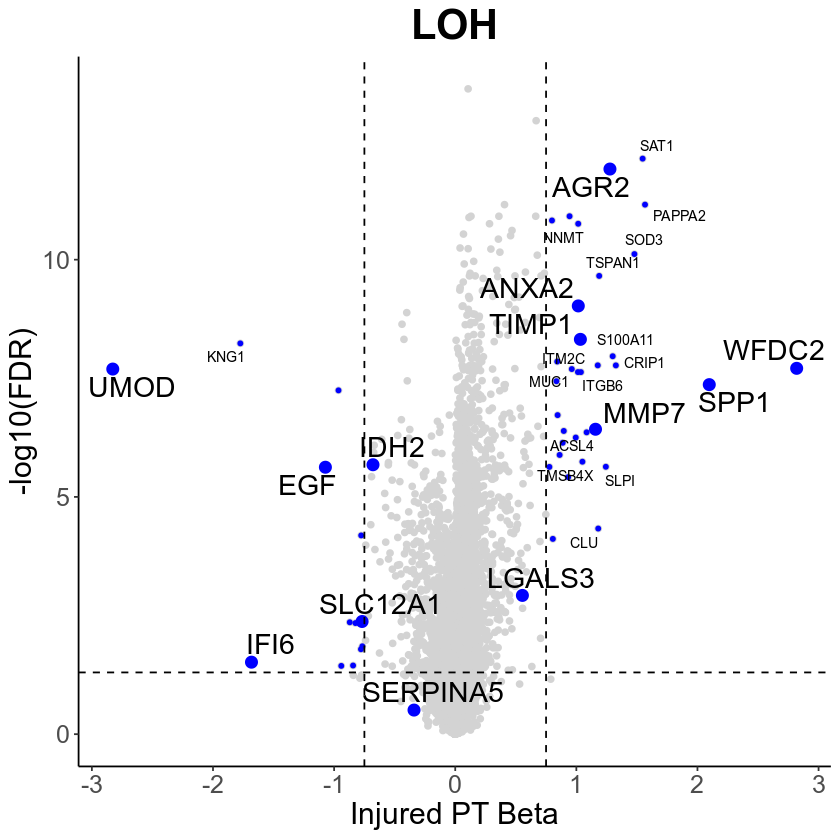

In [21]:
genes <- c("ANXA2", "MMP7", "WFDC2", "SPP1", "TIMP1", "LGALS3", "AGR2",
           "EGF", "UMOD", "IDH2", "SLC12A1", "SERPINA5", "IFI6")

de_plot <- ggplot(de_df,
                aes(x = Beta, y = -log10(FDR))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(FDR < 0.05 & abs(Beta) >= 0.75,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.75, 0.75), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
    theme_classic() + 
    theme(text=element_text(family="Arial"),
          legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(FDR < 0.05 & abs(Beta) >= 1 | 
                                                           gene %in% genes, gene, NA),
                                            label_size = ifelse(gene %in% genes, 6 , 3)),
                                     aes(x = Beta, y = -log10(FDR), 
                                         size = label_size, label = label)
            , color = "black") +
    scale_size_identity() + 
    labs(x = "Injured PT Beta", y = "-log10(FDR)", title = "LOH")
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/supplemental_figures/figure10/figure10k.png",
       de_plot,
       base_height = 8,
       base_width = 8)
de_plot

In [14]:
injured_pt_de <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_injured_pt_differential_expression_08102024.rds') %>% 
            na.omit() %>% 
            arrange(LRP) %>% 
            mutate(FDR = p.adjust(LRP, method = "BH")) %>% 
            filter(FDR < 0.05)
chron_de <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/LOH_chronicity_differential_expression_03082024.rds')%>% 
            na.omit() %>% 
            arrange(LRP) %>% 
            mutate(FDR = p.adjust(LRP, method = "BH")) %>% 
            filter(FDR < 0.05)

In [15]:
plot_df <- chron_de %>% 
                rename(Chron_Beta = Beta) %>% 
                select(gene, Chron_Beta) %>% 
                left_join(injured_pt_de %>% 
                          rename(Injured_PT_Beta = Beta) %>% 
                          select(gene, Injured_PT_Beta)) %>% na.omit()

Joining, by = "gene"


In [16]:
cor.test(plot_df$Chron_Beta, plot_df$Injured_PT_Beta)


	Pearson's product-moment correlation

data:  plot_df$Chron_Beta and plot_df$Injured_PT_Beta
t = 308.81, df = 3040, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9832944 0.9854929
sample estimates:
      cor 
0.9844321 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


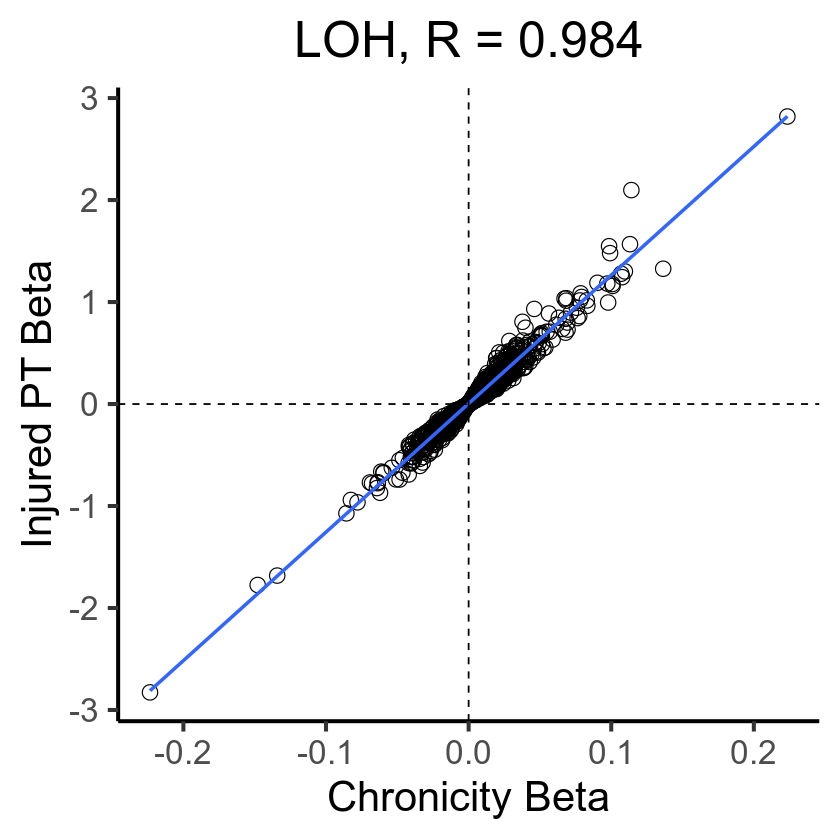

In [22]:
gene_plot <- ggplot(plot_df, aes(x = Chron_Beta, y = Injured_PT_Beta)) + 
                    geom_point(shape = 1, size = 4) + 
                    theme_classic(base_size = 25) + 
                    geom_smooth(method = "lm", se = FALSE) +
                    labs(x = "Chronicity Beta", 
                         y = "Injured PT Beta",
                         title = "LOH, R = 0.984") +
                    geom_vline(xintercept = 0, linetype = "dashed") + 
                    geom_hline(yintercept = 0, linetype = "dashed") +
                    theme(text=element_text(family="Arial"),
                          plot.title=element_text(hjust = 0.5))

cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/supplemental_figures/figure10/figure10l.png",
       gene_plot,
       base_height = 8,
       base_width = 8)
gene_plot